In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
# --- USER CONFIGURATION ---
# paths to your data
WIND_CSV        = "GML/data/wind_power_sdwpf.csv"         # rows: timestamp, cols: turbine IDs, values: wind direction in degrees
POS_CSV         = "GML/data/turbine_location.csv" # cols: ['turbine_id','x','y']
OUTPUT_TIMESTAMP = 4                       # which window index to plot in detail
N_CLUSTERS      = 3                        # how many K‐means clusters on the unit circle
WINDOW_SIZE     = 10                       # how many timestamps per batch
DIRECTION_TOL   = 20                       # degrees tolerance for building edges
MAX_NEIGHBORS   = 1                        # keep only the nearest downstream neighbor
MAX_WINDOWS    = 10                      # how many windows to process
# ----------------------------

In [7]:
# 1. – Load data
wind_df     = pd.read_csv(WIND_CSV,  index_col=0, parse_dates=True)
pos_df      = pd.read_csv(POS_CSV)


C:\Users\daank\AppData\Local\Temp\ipykernel_85916\2120534652.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wind_df     = pd.read_csv(WIND_CSV,  index_col=0, parse_dates=True)


NameError: name 'compute_absolute_wind_direction' is not defined

In [9]:
def normalize_angle(angle):
    """
    Brings any angle in degrees back to [0, 360).
    """
    return angle % 360

In [10]:
def compute_absolute_wind_direction(df):
    """
    Calculate absolute wind direction in degrees relative to true north (0-360°).
    """
    # Handle possible NaN values:
    df = df.copy()
    df['Wdir'] = df['Wdir'].fillna(0)
    df['Ndir'] = df['Ndir'].fillna(0)
    
    # Step 1: add Ndir and Wdir
    df['AbsWdir'] = df['Ndir'] + df['Wdir']
    
    # Step 2: normalize to 0–360 degrees
    df['AbsWdir'] = df['AbsWdir'].apply(normalize_angle)
    
    return df

In [11]:
from calendar import monthrange

# if Day is a day‐count or date and Tmstamp a time-of-day string,
# first build a true datetime index. Adjust the formatting as needed.
# Add a year and month (e.g., "2020-01-") to the date string for parsing
# Create a Datetime column, rolling over days for all months (assuming 2020, non-leap year)

def day_to_date(row):
    day = int(row["Day"])
    month = 1
    year = 2020
    while True:
        days_in_month = monthrange(year, month)[1]
        if day <= days_in_month:
            break
        day -= days_in_month
        month += 1
        if month > 12:
            year += 1
            month = 1
    return f"{year}-{str(month).zfill(2)}-{str(day).zfill(2)} {row['Tmstamp']}"

wind_df["Datetime"] = pd.to_datetime(
    wind_df.apply(day_to_date, axis=1),
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)

# Compute absolute wind direction if raw columns are present
if 'Wdir' in wind_df.columns and 'Ndir' in wind_df.columns:
    wind_df = compute_absolute_wind_direction(wind_df)

# pivot to wide: rows=Datetime, cols=TurbID, vals=AbsWdir
# First, reset index so 'TurbID' is a column
wind_df_reset = wind_df.reset_index()

wind_wide = wind_df_reset.pivot(
    index="Datetime",
    columns="TurbID",
    values="AbsWdir"
).sort_index()

# now overwrite for convenience
wind_df = wind_wide

In [12]:
def cluster_wind_directions(directions, n_clusters=N_CLUSTERS):
    """
    directions: 1D array of angles (°)
    returns: labels (int array), centers (n_clusters × 2) in (cos,sin) coords
    """
    # map angles to unit circle
    radians = np.deg2rad(directions)
    X = np.stack([np.cos(radians), np.sin(radians)], axis=1)
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    return km.labels_, km.cluster_centers_

In [13]:
def compute_dominant_direction(labels, centers):
    """
    picks the largest cluster by count, returns its centroid angle in degrees.
    """
    # find largest cluster
    counts = np.bincount(labels, minlength=centers.shape[0])
    big = counts.argmax()
    cx, cy = centers[big]
    angle = (np.rad2deg(np.arctan2(cy, cx))) % 360
    return angle, big

In [14]:
def build_spatial_graph(pos_df, wind_dir, tol=DIRECTION_TOL, max_neighbors=MAX_NEIGHBORS):
    """
    Constructs a directed graph: edge i->j if j lies within `tol`° of wind_dir
    from i, keeping only the nearest `max_neighbors`.
    """
    G = nx.DiGraph()
    coords = pos_df.set_index("TurbID")[["x","y"]]
    G.add_nodes_from(coords.index)
    angles = {}  # precompute turbine→others angles/distances
    for i,(x0,y0) in coords.iterrows():
        dx = coords.x - x0
        dy = coords.y - y0
        dist = np.hypot(dx,dy)
        with np.errstate(divide="ignore", invalid="ignore"):
            rel_ang = (np.rad2deg(np.arctan2(dy,dx))) % 360
        # compute smallest angular difference to wind_dir
        diff = np.abs(((rel_ang - wind_dir + 180) % 360) - 180)
        mask = (diff <= tol) & (dist>0)
        if not mask.any(): 
            continue
        # pick nearest neighbors
        candidates = dist[mask].nsmallest(max_neighbors)
        for j in candidates.index:
            G.add_edge(i, j, distance=float(dist[j]), rel_angle=float(rel_ang[j]))
    return G

In [15]:
def plot_clusters(pos_df, labels, timestamp):
    plt.figure(figsize=(6,6))
    sc = plt.scatter(pos_df.x, pos_df.y, c=labels, cmap="tab10", s=30)
    for _, row in pos_df.iterrows():
        plt.text(row.x, row.y, str(row.TurbID), fontsize=6)
    plt.title(f"Cluster assignment at {timestamp}")
    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")
    plt.gca().set_aspect("equal", "box")
    plt.show()

In [16]:
def plot_graph(G, pos_df, title):
    """
    G         : a networkx.DiGraph whose nodes are turbine IDs
    pos_df    : DataFrame with cols ['turbine_id','x','y']
    title     : string
    """
    # build a mapping turbine_id -> (x,y)
    # adjust 'turbine_id' below if your column is named differently
    pos = {
        row.TurbID: (row.x, row.y)
        for _, row in pos_df.iterrows()
    }

    plt.figure(figsize=(6,6))
    # Draw nodes at their (x,y) coords:
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color="skyblue")
    # Draw directed edges “downwind”
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle="->",
        arrowsize=8,
        edge_color="gray",
        alpha=0.7,
        width=1
    )

    plt.title(title)
    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")
    plt.gca().set_aspect("equal", "box")
    plt.show()


In [17]:
def cluster_stats(
    dir_angles: np.ndarray, 
    labels:     np.ndarray, 
    centers:    np.ndarray
) -> (pd.DataFrame, tuple):
    """
    Compute per‐cluster statistics and identify the dominant cluster.
    
    Parameters
    ----------
    dir_angles : array_like, shape (M,)
        Raw meteorological wind‐from angles (0°=North, clockwise).
    labels : array_like, shape (M,)
        Integer KMeans labels for each angle.
    centers : array_like, shape (K,2)
        The cluster‐centroid coordinates in (cos, sin) space.
    
    Returns
    -------
    stats_df : pd.DataFrame, index=cluster_id
        Columns:
          - size          : number of points in this cluster
          - proportion    : size / total
          - center_angle  : cluster centroid angle in meteorological degrees
          - circular_std  : circular standard deviation (°) within cluster
    dominant : tuple
        (dominant_cluster_id, dominant_center_angle)
    """
    total = len(labels)
    K     = centers.shape[0]
    rows  = []
    
    for c in range(K):
        mask      = (labels == c)
        n_points  = mask.sum()
        if n_points == 0:
            # empty cluster → skip or record zeros
            rows.append({
                "cluster":      c,
                "size":         0,
                "proportion":   0.0,
                "center_angle": np.nan,
                "circular_std": np.nan
            })
            continue
        
        # 1) centroid math‐angle (0°=E, CCW+)
        cx, cy       = centers[c]
        ang_math     = (np.rad2deg(np.arctan2(cy, cx))) % 360
        
        # 2) convert back to meteorological (0°=N, CW+)
        ang_meteo    = (90.0 - ang_math) % 360.0
        
        # 3) circular std dev of the raw angles in this cluster
        rays      = np.deg2rad(dir_angles[mask])
        R_bar     = np.sqrt(np.mean(np.cos(rays))**2 + np.mean(np.sin(rays))**2)
        circ_std  = np.sqrt(-2 * np.log(R_bar)) * (180.0/np.pi)
        
        rows.append({
            "cluster":      c,
            "size":         int(n_points),
            "proportion":   n_points/total,
            "center_angle": ang_meteo,
            "circular_std": circ_std
        })
    
    stats_df = pd.DataFrame(rows).set_index("cluster")
    
    # Dominant = largest cluster by count
    dominant_id    = stats_df["size"].idxmax()
    dominant_angle = stats_df.at[dominant_id, "center_angle"]
    
    return stats_df, (dominant_id, dominant_angle)


In [37]:
import networkx as nx

# 1. List of prototype angles (degrees) 90 is north

prototype_angles = [90, 135, 180, 215]

# 2. Pre-build each prototype graph G(θᵢ)
#    Define a placeholder function for `make_wake_graph` to create a wake graph.
prototype_graphs = {
    theta: build_spatial_graph(
        pos_df,
        dom_math_to=theta,
        tol=DIRECTION_TOL,
        max_neighbors=MAX_NEIGHBORS
    )
    for theta in prototype_angles
}


TypeError: build_spatial_graph() got an unexpected keyword argument 'dom_math_to'

In [32]:
import numpy as np

def select_prototype_graph(phi_deg):
    """
    Map any phi in [0,360) into [0,180), then pick the nearest prototype.
    Returns the corresponding graph.
    """
    # fold into [0,180)
    folded = phi_deg % 180
    # find argmin |folded - θᵢ|
    best = min(prototype_angles,
               key=lambda theta: abs(folded - theta))
    return best, prototype_graphs[best]


Window 0: dominant meteo 343.0°, mapped math→template 287.0°, assigned prototype 90°


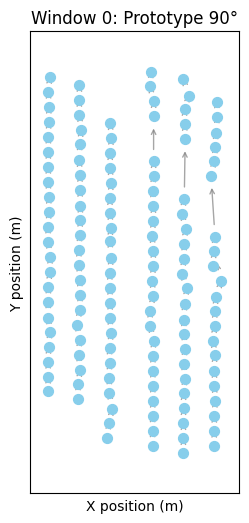

Window 1: dominant meteo 347.9°, mapped math→template 282.1°, assigned prototype 90°


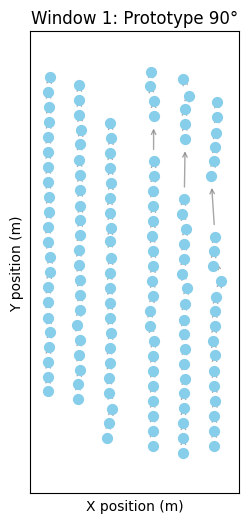

Window 2: dominant meteo 331.7°, mapped math→template 298.3°, assigned prototype 135°


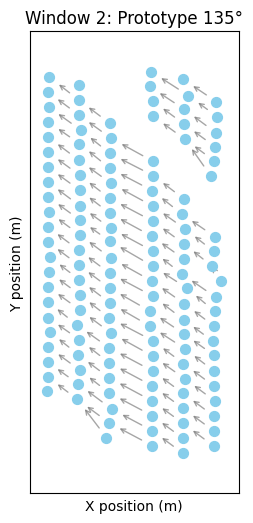

Window 3: dominant meteo 329.5°, mapped math→template 300.5°, assigned prototype 135°


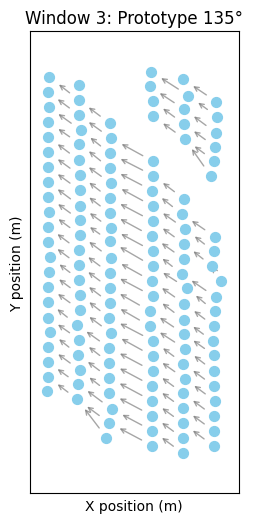

Window 4: dominant meteo 321.0°, mapped math→template 309.0°, assigned prototype 135°


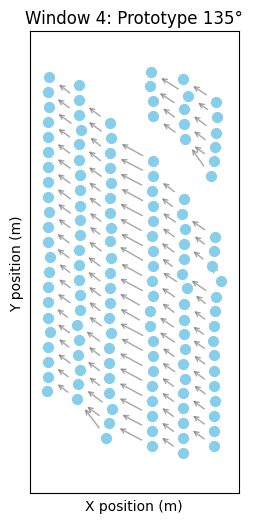

Window 5: dominant meteo 319.4°, mapped math→template 310.6°, assigned prototype 135°


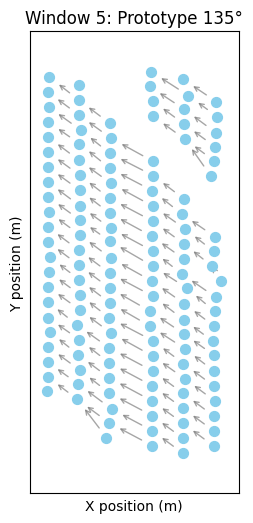

Window 6: dominant meteo 329.1°, mapped math→template 300.9°, assigned prototype 135°


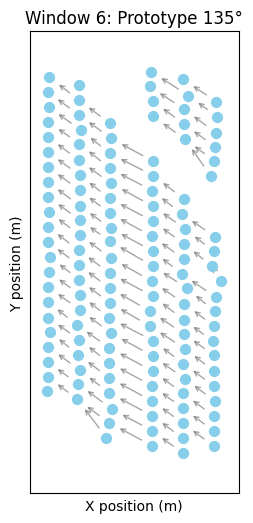

Window 7: dominant meteo 31.9°, mapped math→template 238.1°, assigned prototype 45°


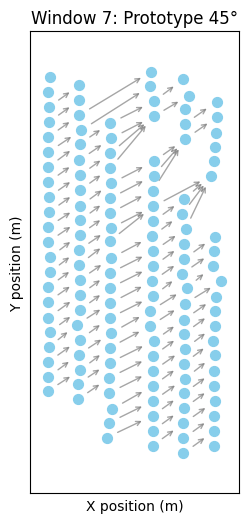

Window 8: dominant meteo 43.0°, mapped math→template 227.0°, assigned prototype 45°


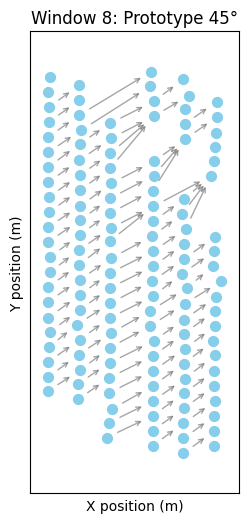

Window 9: dominant meteo 46.8°, mapped math→template 223.2°, assigned prototype 45°


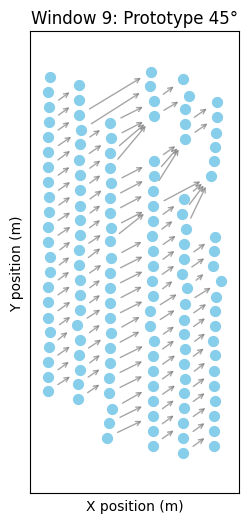

Stopping after 10 windows.


In [35]:
# ─── 0) Prototype setup ───────────────────────────────────────────────
# 4 equally spaced “base” wind directions (°)
prototype_angles = [0, 45, 90, 135]

# Pre-build each prototype graph once
prototype_graphs = {
    θ: build_spatial_graph(
            pos_df,
            wind_dir=θ,             # rotate template to θ
            tol=DIRECTION_TOL,
            max_neighbors=MAX_NEIGHBORS
        )
    for θ in prototype_angles
}

# ─── 1) Compute absolute wind direction if needed ─────────────────────
if 'Wdir' in wind_df.columns and 'Ndir' in wind_df.columns:
    wind_df = compute_absolute_wind_direction(wind_df)


# 2) – Main loop over sliding windows of timestamps ────────────────────
window_graphs     = []
window_directions = []
window_labels     = []
timestamps        = wind_df.index.tolist()

for idx, wstart in enumerate(range(0, len(timestamps), WINDOW_SIZE)):
    if idx >= MAX_WINDOWS:
        print(f"Stopping after {MAX_WINDOWS} windows.")
        break

    window_ts   = timestamps[wstart : wstart+WINDOW_SIZE]
    dir_block   = wind_df.loc[window_ts]

    # 1) raw → math angles
    dir_raw  = pd.to_numeric(dir_block.values.flatten(), errors="coerce")
    dir_raw  = dir_raw[~np.isnan(dir_raw)]
    dir_math = (90.0 - dir_raw) % 360.0

    # 2) cluster & dominant direction
    labels_math, centers = cluster_wind_directions(dir_math, n_clusters=N_CLUSTERS)
    dom_math, _          = compute_dominant_direction(labels_math, centers)
    dom_meteo = (90.0 - dom_math) % 360.0
    dom_math_to = (dom_math + 180) % 360

    # 3) select & display prototype
    best_angle, G_proto = select_prototype_graph(dom_math_to)
    print(f"Window {idx}: dominant meteo {dom_meteo:.1f}°, "
          f"mapped math→template {dom_math_to:.1f}°, "
          f"assigned prototype {best_angle}°")

    # plot the prototype graph
    plot_graph(
        G_proto,
        pos_df,
        title=f"Window {idx}: Prototype {best_angle}°"
    )

    # 4) store for downstream
    window_graphs.append(G_proto)
    window_directions.append(dom_meteo)
    # rebuild your labels_2d as before…
    full_size    = WINDOW_SIZE
    labels_full  = np.full(dir_raw.shape, -1, dtype=int)
    labels_full[labels_math >= 0] = labels_math
    labels_2d     = labels_full.reshape(len(window_ts), -1)
    window_labels.append((window_ts, labels_2d))

    # #start an empty graph with all nodes
    # G_union =nx.DiGraph()
    # G_union.add_nodes_from(pos_df.TurbID)

    # # 2) for each timestamp in the window, build its cluster‐wise graph
    # for t_idx in range(len(window_ts)):     # or range(WINDOW_SIZE)
    #     labels_t = labels_2d[t_idx]         # cluster assignments at that minute
    #     G_t      = build_cluster_wise_graph(
    #                   pos_df,
    #                   labels_t,
    #                   centers,
    #                   tol=DIRECTION_TOL,
    #                   max_neighbors=MAX_NEIGHBORS
    #                )
    #     # 3) merge the current graph into the union
    #     G_union.add_edges_from(G_t.edges(data=True))
    
    # # 4) plot the union graph
    #     plot_graph(
    #     G_union,
    #     pos_df,
    #     f"Union of cluster‐wise graphs\nwindow {idx}"
    #     )


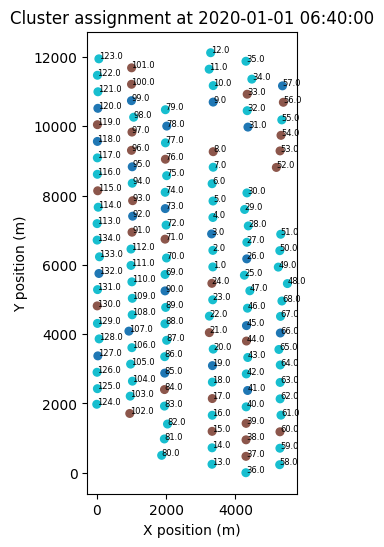

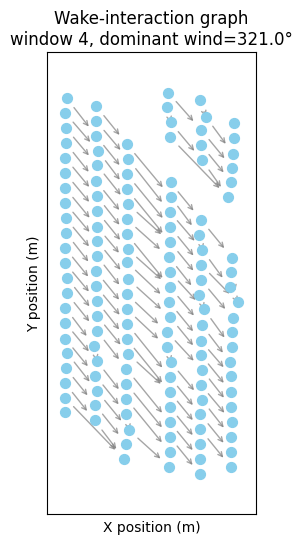

In [22]:
# 4. – Plot the RESULTS for one window of your choice
i = OUTPUT_TIMESTAMP
ts_window, labels2d = window_labels[i]

# Ensure labels match the number of turbines for plotting
# If labels2d is 2D and has more than one row, select the first row's N labels (N = number of turbines)
if labels2d.ndim == 2 and labels2d.shape[0] > 1:
    labels_single = labels2d[0][:len(pos_df)]
else:
    labels_single = labels2d[:len(pos_df)]

plot_clusters(pos_df, labels_single, ts_window[0])

# plot the corresponding graph
plot_graph(window_graphs[i], pos_df,
           f"Wake‐interaction graph\nwindow {i}, dominant wind={window_directions[i]:.1f}°")

In [ ]:
#not used yet but could be useful for further analysis. Making a graph based on cluster-wise wind directions

import networkx as nx
import numpy as np

def build_cluster_wise_graph(
    pos_df,
    labels_per_node: np.ndarray,
    centers: np.ndarray,
    tol: float = 20.0,
    max_neighbors: int = 1
) -> nx.DiGraph:
    """
    Build a directed graph where each turbine i has outgoing edges
    based on *its* cluster's dominant wind-to (downwind) direction.

    Parameters
    ----------
    pos_df : DataFrame
        Must have columns ['turbine_id','x','y'].
    labels_per_node : array of shape (N,)
        cluster ID for each turbine (length N).
    centers : array of shape (K,2)
        KMeans cluster‐centroids in (cos, sin) space (math convention).
    tol : float
        angular tolerance (°) for “downwind” linkage.
    max_neighbors : int
        keep only the nearest `max_neighbors` downstream turbines.

    Returns
    -------
    G : nx.DiGraph
        Nodes are turbine IDs, with attrs distance & rel_angle on edges.
    """

    # 1) precompute each cluster's math-angle & downwind angle:
    K = centers.shape[0]
    dom_math = np.rad2deg(np.arctan2(centers[:,1], centers[:,0])) % 360
    # flip 180° for “to” (downwind)
    dom_math_to = (dom_math + 180.0) % 360

    # 2) build graph
    G = nx.DiGraph()
    coords = pos_df.set_index("TurbID")[["x","y"]]
    G.add_nodes_from(coords.index)

    for i, cl in zip(coords.index, labels_per_node):
        wind_dir = dom_math_to[cl]
        x0, y0 = coords.loc[i]
        dx = coords.x - x0
        dy = coords.y - y0
        dist = np.hypot(dx, dy)
        rel_ang = (np.rad2deg(np.arctan2(dy, dx))) % 360
        # angular difference
        diff = np.abs(((rel_ang - wind_dir + 180) % 360) - 180)
        mask = (diff <= tol) & (dist > 0)
        if not mask.any():
            continue

        # pick nearest downstream neighbors
        neigh = dist[mask].nsmallest(max_neighbors)
        for j in neigh.index:
            G.add_edge(i, j,
                       distance=float(dist[j]),
                       rel_angle=float(rel_ang[j]))
    return G


Prototype graph at 0°:
  - Nodes: 134
  - Edges: 110
  - Sample edges: [(1, 25, {'distance': 941.9162376173862, 'rel_angle': 345.2708785767324}), (2, 26, {'distance': 1007.6808763648767, 'rel_angle': 345.9483518882584}), (3, 27, {'distance': 1045.4157238637772, 'rel_angle': 346.6425881009641}), (4, 29, {'distance': 943.9190780347975, 'rel_angle': 14.217202229344949}), (5, 29, {'distance': 943.6472496108746, 'rel_angle': 345.0628003826623})]



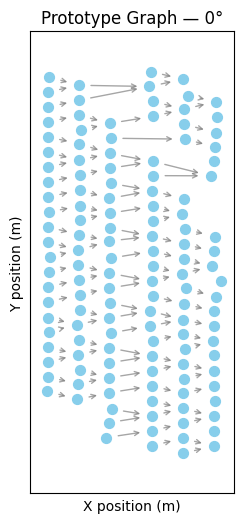

Prototype graph at 45°:
  - Nodes: 134
  - Edges: 103
  - Sample edges: [(1, 27, {'distance': 1212.6780347963543, 'rel_angle': 35.92066287257348}), (2, 28, {'distance': 1242.3062399950813, 'rel_angle': 34.63124507865788}), (3, 29, {'distance': 1185.3473547985363, 'rel_angle': 36.54279581287091}), (4, 30, {'distance': 1211.030180022893, 'rel_angle': 35.83212636422012}), (5, 52, {'distance': 2068.715869251421, 'rel_angle': 27.943921001274088})]



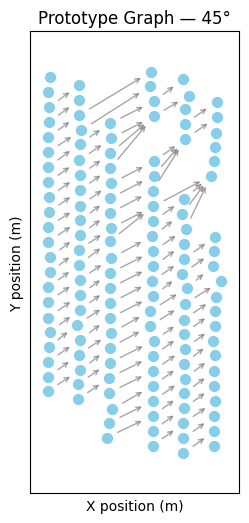

Prototype graph at 90°:
  - Nodes: 134
  - Edges: 128
  - Sample edges: [(1, 2, {'distance': 477.4161855436831, 'rel_angle': 89.86196180325655}), (2, 3, {'distance': 476.9147522244701, 'rel_angle': 94.35584810133021}), (3, 4, {'distance': 475.4246718269643, 'rel_angle': 85.49843931980652}), (4, 5, {'distance': 475.0708232153166, 'rel_angle': 89.60827284569585}), (5, 6, {'distance': 500.2675463483943, 'rel_angle': 92.96922056635002})]



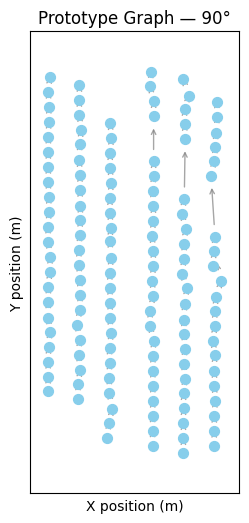

Prototype graph at 135°:
  - Nodes: 134
  - Edges: 106
  - Sample edges: [(1, 71, {'distance': 1594.3659647933546, 'rel_angle': 149.82576251127134}), (2, 72, {'distance': 1533.8122769674155, 'rel_angle': 151.6027191087452}), (3, 73, {'distance': 1524.2952226233153, 'rel_angle': 151.35691619967525}), (4, 74, {'distance': 1557.4991892857822, 'rel_angle': 152.1760663213664}), (5, 75, {'distance': 1524.55720691743, 'rel_angle': 151.34673950498305})]



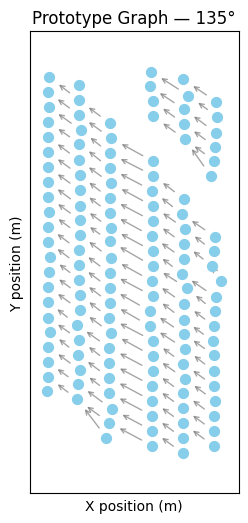